In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
'''
IMAGE PROCESSING
'''
import sys
import argparse
import cv2
from libfaceid.detector import FaceDetectorModels, FaceDetector
from libfaceid.encoder  import FaceEncoderModels, FaceEncoder
from libfaceid.pose import FacePoseEstimatorModels, FacePoseEstimator
from libfaceid.age import FaceAgeEstimatorModels, FaceAgeEstimator
from libfaceid.gender import FaceGenderEstimatorModels, FaceGenderEstimator
from libfaceid.emotion import FaceEmotionEstimatorModels, FaceEmotionEstimator

Using TensorFlow backend.


In [3]:
'''
STREAMING
'''
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import time

In [4]:
'''
STREAMING CONTROL
'''
import threading
import asyncio

In [5]:
'''
BUTTON CONTROLS
'''
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
streaming_toggle = widgets.ToggleButton(
                        value=False,
                        description='Start Streaming',
                        disabled=False,
                        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
                        tooltip='Streaming',
                        icon='play'
                    )

# show_result_button = widgets.Button(description="Show Result")
show_result_button = widgets.Button(description='Show Results',
           layout= widgets.Layout(width='40%', height='40px'))

In [6]:
INPUT_DIR_DATASET               = "datasets"
INPUT_DIR_MODEL_DETECTION       = "models/detection/"
INPUT_DIR_MODEL_ENCODING        = "models/encoding/"
INPUT_DIR_MODEL_TRAINING        = "models/training/"
INPUT_DIR_MODEL_ESTIMATION      = "models/estimation/"

In [7]:
RESOLUTION_QVGA   = (320, 240)
RESOLUTION_VGA    = (640, 480)
RESOLUTION_HD     = (1280, 720)
RESOLUTION_FULLHD = (1920, 1080)

In [8]:
'''
STREAMING HELPER FUNCTIONS
'''
def show_init_screen():
    image_data = cv2.imread("init_screen.jpeg")
    image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGBA)
    image_data = cv2.flip(image_data, 0)
    myImage.data_source.data['image']=[image_data]
    push_notebook()

def cam_init(cam_index, width, height): 
    cap = cv2.VideoCapture(cam_index)
    if sys.version_info < (3, 0):
        cap.set(cv2.cv.CV_CAP_PROP_FPS, 30)
        cap.set(cv2.cv.CV_CAP_PROP_FRAME_WIDTH,  width)
        cap.set(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT, height)
    else:
        cap.set(cv2.CAP_PROP_FPS, 30)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH,  width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    return cap

def label_face(frame, face_rect, face_id, confidence):
    (x, y, w, h) = face_rect
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 255), 1)
    if face_id is not None:
        cv2.putText(frame, "{} {:.2f}%".format(face_id, confidence), 
            (x+5,y+h-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

![title](intro.png)

In [9]:
output_notebook()
emotions = []

cam_index = 0
cam_resolution = RESOLUTION_VGA
model_detector=FaceDetectorModels.HAARCASCADE
model_poseestimator=FacePoseEstimatorModels.DEFAULT
model_ageestimator=FaceAgeEstimatorModels.DEFAULT
model_genderestimator=FaceGenderEstimatorModels.DEFAULT
model_emotionestimator=FaceEmotionEstimatorModels.DEFAULT


# Initialize the camera
camera = cam_init(cam_index, cam_resolution[0], cam_resolution[1])

ret, frame = camera.read()
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
frame=cv2.flip(frame, 0) # because Bokeh flips vertically

width=frame.shape[1]
height=frame.shape[0]
p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
show(p, notebook_handle=True)


push_notebook()


try:
    # Initialize face detection
    face_detector = FaceDetector(model=model_detector, path=INPUT_DIR_MODEL_DETECTION)#, optimize=True)
    # Initialize face pose/age/gender estimation
    face_pose_estimator = FacePoseEstimator(model=model_poseestimator, path=INPUT_DIR_MODEL_ESTIMATION)
    face_age_estimator = FaceAgeEstimator(model=model_ageestimator, path=INPUT_DIR_MODEL_ESTIMATION)
    face_gender_estimator = FaceGenderEstimator(model=model_genderestimator, path=INPUT_DIR_MODEL_ESTIMATION)
    face_emotion_estimator = FaceEmotionEstimator(model=model_emotionestimator, path=INPUT_DIR_MODEL_ESTIMATION)
except:
    print("Warning, check if models and trained dataset models exists!")
(age, gender, emotion) = (None, None, None)

print("\nCamera Reesolution: {0}X{1}".format(width, height))


t_end = time.time() + 60 * 0.5

while time.time() < t_end:
    sys.stdout.write('\r'+ "Time Remaining: " + str(int(round(t_end - time.time(),0))) + " (sec)")

    # Capture frame from webcam
    t1 = time.time()
    ret, frame = camera.read()
    
    
    if frame is None:
        print("Error, check if camera is connected!")
        break

    # Detect and identify faces in the frame
    faces = face_detector.detect(frame)
    for (index, face) in enumerate(faces):
        (x, y, w, h) = face

        # Detect age, gender, emotion
        face_image = frame[y:y+h, h:h+w]
        age = face_age_estimator.estimate(frame, face_image)
        gender = face_gender_estimator.estimate(frame, face_image)
        emotion = face_emotion_estimator.estimate(frame, face_image)
        emotions.append(emotion)

        # Detect and draw face pose locations
        shape = face_pose_estimator.detect(frame, face)
        face_pose_estimator.add_overlay(frame, shape)

        # Display age, gender, emotion

    cv2.putText(frame, "Age: {}".format(age), 
        (x, y-45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Gender: {}".format(gender), 
        (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Emotion: {}".format(emotion), 
        (x, y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
    # Display updated frame to Jupyter Notebook
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame=cv2.flip(frame, 0) # because Bokeh flips vertically
    t2 = time.time()
    myImage.data_source.data['image']=[frame]
    s = f"""{int(1/(t2-t1))} FPS"""
    p.title.text = s
   

    push_notebook()
    time.sleep(0.2)
    
camera.release()


Loading BokehJS ...

Instructions for updating:
Colocations handled automatically by placer.

Camera Reesolution: 640X480
Time Remaining: 0 (sec))

In [10]:
"""
SHOW EMOTION RESULT
"""
import pandas
from collections import Counter
def on_button_clicked(b):
    letter_counts = Counter(emotions)
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    df.plot.barh()

		    Facial Emotion


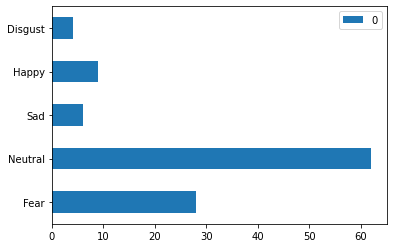

In [11]:
# display(show_result_button)
# show_result_button.on_click(on_button_clicked)
letter_counts = Counter(emotions)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot.barh()
print("\t\t    Facial Emotion")

In [12]:
print("\t\t    Voice Emotion")
print("\t\t     Positive!🤩")

		    Voice Emotion
		     Positive!🤩


<br>
<br>
<br>
<br>
<br>
<br>
© 2020 Zoomate All rights reserved.
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>